In [54]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns
rng = np.random.default_rng()

In [55]:
n_examples = 5000
test_size = 1000
extra_rounds = 100
selected_classes = [4, 9]

train_path = "./data/mnist_train.csv"
test_path = "./data/mnist_test.csv"

#Note -- place your own MNIST files in the appropriate directory
train_data = np.loadtxt(train_path, delimiter=',')
test_data = np.loadtxt(test_path, delimiter=',')
# In[3]:


train_imgs = train_data[:, 1:]
test_imgs = test_data[:, 1:]
train_labels = train_data[:, 0]
test_labels = test_data[:, 0]

In [56]:
def binarize(x):
    return np.where(np.greater(x / 255., 0.25), 1.0, 0.0)

In [57]:
def k_cap(input, cap_size):
	output = np.zeros_like(input)
	if len(input.shape) == 1:
		idx = np.argsort(input)[-cap_size:]
		output[idx] = 1
	else:
		idx = np.argsort(input, axis=-1)[:, -cap_size:]
		np.put_along_axis(output, idx, 1, axis=-1)
	return output

In [58]:
n_in = 784
n_neurons = 2000
cap_size = 200
cap_inference = 200
sparsity = 0.1
n_rounds = 15
beta = 1

In [59]:
from scipy.signal import convolve

# for each class load and preprocess 5000 images
examples = np.zeros((10, n_examples, 784))

for i in range(10):
    examples[i] = binarize(train_imgs[train_labels == i][:n_examples])
# 	examples[i] = k_cap(convolve(train_imgs[train_labels == i][:n_examples].reshape(-1, 28, 28), np.ones((1, 3, 3)), mode='same').reshape(-1, 28 * 28), cap_size)


In [60]:
def train_predict(selected_classes, extra_rounds):
    # construct an erdos renyi graph (brain area) and normalize the synaptic weights
    mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
    W = np.ones((n_neurons, n_neurons)) * mask
    W /= W.sum(axis=0)
    # construct the stimulus area
    mask_a = rng.random((n_in, n_neurons)) < sparsity
    A = np.ones((n_in, n_neurons)) * mask_a
    A /= A.sum(axis=0)


    W = np.ones_like(W) * mask
    A = np.ones_like(A) * mask_a
    W /= W.sum(axis=0, keepdims=True)
    A /= A.sum(axis=0, keepdims=True)
    bias = np.zeros(n_neurons)
    b = -1

    # for each class show a few samples. After each class is shown renormalize the weights. Training time
    overlaps = []
    # train phase
    activations = np.zeros((10, n_rounds, n_neurons), dtype=int)
    act_stimulus = np.zeros((10, n_neurons), dtype=int)
    for idx, i in enumerate(selected_classes):
        act_h = np.zeros(n_neurons)
        tmp = []
        class_activations = []
        for j in range(n_rounds):
            input = examples[i, j].astype(int)
            act_h_new = k_cap(act_h @ W + input @ A + bias, cap_size)
            # count overlap
            assembly_idx = np.where(act_h_new > 0)[0]
            # class_activations.append(assembly_idx)
            assembly = W[assembly_idx[:,None], assembly_idx[None,:]]
            # activations contains which fired in the brain area. Recurrent connection fire and fire from stimuli
            activations[i, j] = act_h_new.copy()

            A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            act_h = act_h_new

        act_stimulus[i] = k_cap(input @ A, cap_size).astype(int)
        overlaps.append(tmp)
        bias[act_h > 0] += b
        A /= A.sum(axis=0, keepdims=True)
        W /= W.sum(axis=0, keepdims=True)

    # show again the examples without the bias. Reconfigure misclassified weights
    for sample in range(extra_rounds):
        class_activations = []
        for idx, i in enumerate(selected_classes):
            act_h = np.zeros(n_neurons, dtype=int)
            for j in range(n_rounds):
                input = examples[i, sample]
                act_stimulus_new = k_cap(input @ A, cap_size).astype(int)
                act_h_new = k_cap(act_h @ W + input @ A, cap_size).astype(int)
                assembly_idx = np.where(act_h_new > 0)[0]
                assembly = W[assembly_idx[:,None], assembly_idx[None,:]]
                overlap = (np.array(act_h, dtype=bool) & np.array(act_h_new, dtype=bool)).sum()
                other_class = selected_classes[(idx + 1) % len(selected_classes)]
                overlap_curr = act_h_new & activations[i, -1]
                overlap_other = act_h_new & activations[other_class, -1]
                act_h = act_h_new
                # Readjust weights so that the correct assembly will fire and reset activations
                if overlap_other.sum() > overlap_curr.sum():
# 					print(f'mismatch class:{i}, sample:{sample} round:{j}, overlap_curr:{overlap_curr.sum()}, overlap_other:{overlap_other.sum()}')
                    overlap_stimulus_curr = act_stimulus_new & act_stimulus[i]
                    overlap_stimulus_other = act_stimulus_new & act_stimulus[other_class]
                    remaining_other = act_stimulus[other_class] & ~overlap_stimulus_other
                    activated_pixels = np.where(input > 0)[0]
                    A[(input > 0)[:, None] & (overlap_stimulus_other > 0)[None, :]] *= 0.9
                    A[(input > 0)[:, None] & (remaining_other > 0)[None, :]] *= 0.9
                    A[(input > 0)[:, None] & (overlap_stimulus_curr > 0)[None, :]] *= 0.95
                    # clear previous winners
                    act_h = np.zeros(n_neurons, dtype=int)
            A /= A.sum(axis=0, keepdims=True)

    # show examples to the trained area and record the activity
    # outputs[i][j]: for class i and round j for all 5000 examples show which neurons fired 
    outputs = np.zeros((10, n_rounds+1, n_examples, n_neurons), dtype=int)
    for i in selected_classes:
        tmp = []
        for j in range(n_rounds):
            outputs[i, j+1] = k_cap(outputs[i, j] @ W + examples[i] @ A, cap_inference)
    assembly_similarity = []

    confusion_matrix = np.zeros((10, 10), dtype=int)
    # make predictions
    overlaps = np.array([])
    for idx, actual_class in enumerate(selected_classes):
        overlap = np.zeros((10, n_examples, n_neurons), dtype=int)
        for testing_class in selected_classes:
            overlap[testing_class] = outputs[actual_class, -1] & activations[testing_class, -1]
        tmp = overlap.sum(axis=2).reshape(-1)
        overlaps = np.hstack([overlaps, tmp[tmp > 0]])
        overlaps_sum = overlap.sum(axis=2)
        preds = np.argmax(overlaps_sum, axis=0)[extra_rounds:]
        correct  = (preds == actual_class).sum()
        hist, _ = np.histogram(preds, bins=np.arange(11))
        confusion_matrix[actual_class] = hist
# 		print(f'actual_class:{actual_class}, accuracy:{correct}/{n_examples}')
    return confusion_matrix

In [61]:
acc_matrix_no_correction = np.zeros((10, 10))
acc_matrix_correction = np.zeros((10, 10))
for i in range(10):
    for j in range(i+1, 10):
        conf_mat_correction = train_predict([i, j], extra_rounds)
        conf_mat_no_correction = train_predict([i, j], 0)
        accuracy_correction = sum(conf_mat_correction[i, i] for i in [i, j]) / (2 * (n_examples - extra_rounds))
        accuracy_no_correction = sum(conf_mat_no_correction[i, i] for i in [i, j]) / (n_examples * 2)
#         print(f'[{i}, {j}] accuracy:correction:{accuracy_correction}, accuracy_no_correction:{accuracy_no_correction}')
        acc_matrix_no_correction[i][j] = accuracy_no_correction
        acc_matrix_correction[i][j] = accuracy_correction
        print(f'[{i}, {j}]: corr:{accuracy_correction}, no_corr:{accuracy_no_correction}')

[0, 1]: corr:0.9916326530612245, no_corr:0.9873
[0, 2]: corr:0.9088775510204081, no_corr:0.8721
[0, 3]: corr:0.958469387755102, no_corr:0.9
[0, 4]: corr:0.9871428571428571, no_corr:0.9839
[0, 5]: corr:0.9076530612244897, no_corr:0.6587
[0, 6]: corr:0.9458163265306122, no_corr:0.9078
[0, 7]: corr:0.9479591836734694, no_corr:0.9249
[0, 8]: corr:0.9533673469387756, no_corr:0.9324
[0, 9]: corr:0.9424489795918367, no_corr:0.9349
[1, 2]: corr:0.9612244897959183, no_corr:0.8199
[1, 3]: corr:0.9355102040816327, no_corr:0.9077
[1, 4]: corr:0.9411224489795919, no_corr:0.9303
[1, 5]: corr:0.9086734693877551, no_corr:0.8244
[1, 6]: corr:0.9406122448979591, no_corr:0.8952
[1, 7]: corr:0.9551020408163265, no_corr:0.9377
[1, 8]: corr:0.9157142857142857, no_corr:0.8003
[1, 9]: corr:0.9339795918367347, no_corr:0.9261
[2, 3]: corr:0.8821428571428571, no_corr:0.8425
[2, 4]: corr:0.9213265306122449, no_corr:0.8076
[2, 5]: corr:0.9033673469387755, no_corr:0.7737
[2, 6]: corr:0.8924489795918368, no_corr:0.8

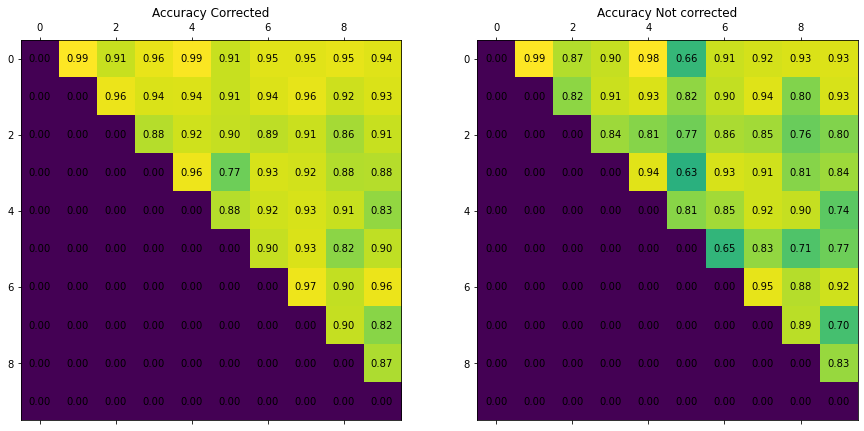

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.title.set_text('Accuracy Corrected')
ax1.matshow(acc_matrix_correction)
for (i, j), z in np.ndenumerate(acc_matrix_correction):
    ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
ax2.title.set_text('Accuracy Not corrected')
ax2.matshow(acc_matrix_no_correction)
for (i, j), z in np.ndenumerate(acc_matrix_no_correction):
    ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
plt.show()

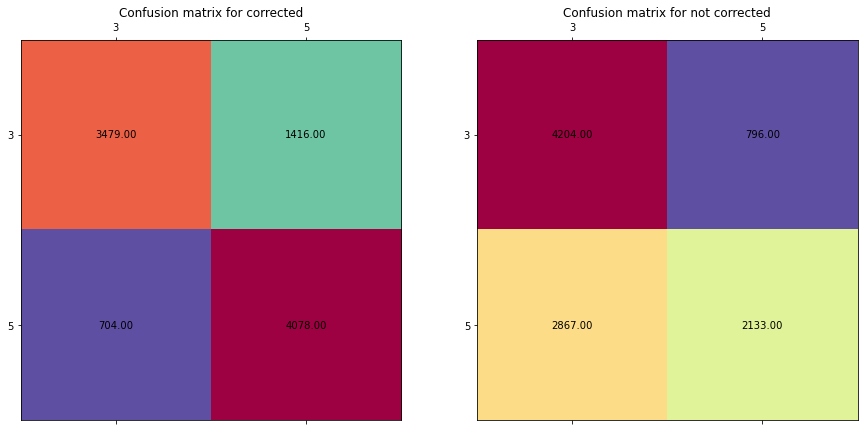

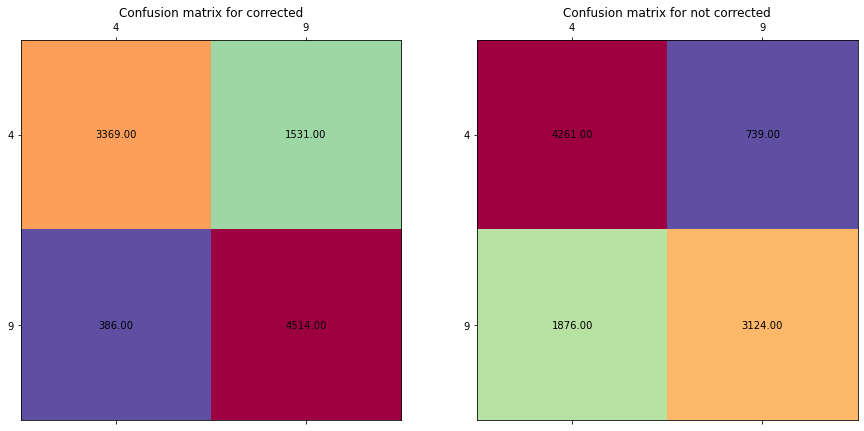

In [66]:
test_classes = [[3, 5], [4, 9]]
for test_class in test_classes:
    test_class = np.array(test_class)
    conf_mat_correction = train_predict(test_class, extra_rounds)
    conf_mat_no_correction = train_predict(test_class, 0)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    conf_mat_correction = conf_mat_correction[test_class[:, None], test_class[None, :]]
    conf_mat_no_correction = conf_mat_no_correction[test_class[:, None], test_class[None, :]]

    ax1.matshow(conf_mat_correction, cmap=cm.Spectral_r)
    ax1.title.set_text('Confusion matrix for corrected')
    ax1.set_xticks([0, 1])
    ax1.set_yticks([0, 1])
    ax1.set_xticklabels(test_class)
    ax1.set_yticklabels(test_class)
    for (i, j), z in np.ndenumerate(conf_mat_correction):
        ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    ax2.matshow(conf_mat_no_correction, cmap=cm.Spectral_r)
    ax2.title.set_text('Confusion matrix for not corrected')
    ax2.set_xticks([0, 1])
    ax2.set_yticks([0, 1])
    ax2.set_xticklabels(test_class)
    ax2.set_yticklabels(test_class)
    for (i, j), z in np.ndenumerate(conf_mat_no_correction):
        ax2.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.show()